In [1]:
%env PATH=/usr/local/cuda-11.5/bin:$PATH

env: PATH=/usr/local/cuda-11.5/bin:$PATH


In [2]:
from pinns.prelude import *
from pinns.domain import Hypercube
from pinns.calc import laplace
from pinns.opt import train_nn
from pinns.model import mlp
from scipy.stats.qmc import Sobol
import matplotlib.pyplot as plt

In [3]:
domain = Hypercube((0., 0.), (1., 1.))
x_dom = array(Sobol(2, seed=0).random_base2(10))
x_dom = domain.transform(x_dom)
x_bnd = array(Sobol(1, seed=1).random_base2(8))
x_bnd = domain.transform_bnd(x_bnd)


In [4]:
key, init_key = random.split(random.PRNGKey(503))
model, params = mlp(init_key, (2, 16, 16, 1), tanh)

tx = optax.adam(0.001)
init_state = TrainState.create(
    apply_fn=model.apply, 
    params=params,
    tx=tx
)


def loss(params, x_dom, x_bnd):
    l1 = lambda x, p: laplace(model)(x, p) + sin(2*pi * x[0]) * sin(2*pi * x[1])
    l2 = lambda x, p: model.apply(p, x)
    _l1 = mean(vmap(l1, (0, None))(x_dom, params) ** 2)
    _l2 = mean(vmap(l2, (0, None))(x_bnd, params) ** 2)
    _loss = _l1 + _l2
    return _loss, {'pde_loss': _l1, 'bnd_loss': _l2, 'loss': _loss}

def batch_fn(rng):
    batches = 24
    k1, k2 = random.split(rng)
    batch_size_dom = x_dom.shape[0] // batches
    batch_size_bnd = x_bnd.shape[0] // batches

    perms_dom = jax.random.permutation(k1, x_dom.shape[0])
    perms_dom = perms_dom[:batches * batch_size_dom]  # skip incomplete batch
    perms_dom = perms_dom.reshape((batches, batch_size_dom))

    perms_bnd = jax.random.permutation(k2, x_bnd.shape[0])
    perms_bnd = perms_bnd[:batches * batch_size_bnd]  # skip incomplete batch
    perms_bnd = perms_bnd.reshape((batches, batch_size_bnd))

    return x_dom[perms_dom, :], x_bnd[perms_bnd, :]

In [5]:
key, train_key = random.split(key)
state, metrics = train_nn(loss, init_state, batch_fn, train_key, epochs=2000)

In [7]:
plt.plot(metrics['loss'])

TypeError: tuple indices must be integers or slices, not str

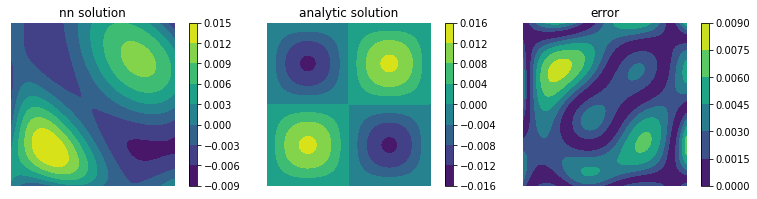

In [14]:
import matplotlib.pyplot as plt



def plot_solution(model, params, name=None):
    x = linspace(0, 1, 100)
    y = linspace(0, 1, 100)
    X, Y = meshgrid(x, y, indexing='xy')

    @jnp.vectorize
    def _sol(x, y):
        _x = stack((x, y))
        y = model.apply(params, _x)
        return y#[0]

    def nn_sol(x, y):
        return _sol(x, y)

    def analytic_sol_func(x,y):
        return  sin(2 * pi * x) * sin(2 * pi * y) / (8 * pi ** 2)

    f = plt.figure(figsize=(13, 3))
    ax1, ax2, ax3 = f.subplots(1, 3)
    y_nn = nn_sol(X, Y)
    y_analytic = analytic_sol_func(X, Y)

    plt.sca(ax1)
    plt.axis('equal')
    plt.title("nn solution")
    p = plt.contourf(X, Y, y_nn)
    plt.colorbar(p)
    plt.axis("off")

    plt.sca(ax2)
    plt.axis('equal')
    plt.title("analytic solution")
    plt.contourf(X, Y, y_analytic)
    plt.colorbar()
    plt.axis("off")

    plt.sca(ax3)
    plt.axis('equal')
    plt.title("error")
    p = plt.contourf(X, Y, abs(y_nn - y_analytic))
    plt.colorbar(p)
    plt.axis("off")
    if name is not None:
        plt.savefig(name)

plot_solution(model, {'params': state.params})